# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [4]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

%pip install lightgbm

%pip install geopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

import math
import requests
from geopy.distance import geodesic
from lightgbm import LGBMRegressor
pd.set_option('display.max_columns',None)

## 2. Data Load

#### 2.1. 데이터 로드

In [6]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [7]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [8]:
pd.set_option('display.max_columns',None)

In [9]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,언주로 3,NaN,,직거래,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [10]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [11]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [12]:
concat['단지소개기존clob'].unique()

array([      nan, 2.888e+03, 3.170e+02, 7.870e+02, 4.000e+00, 1.740e+02,
       2.038e+03, 1.190e+02, 6.240e+02, 2.048e+03, 1.030e+02, 1.220e+02,
       4.600e+02, 4.130e+02, 2.300e+01, 1.970e+02, 2.970e+02, 2.286e+03,
       1.269e+03, 6.400e+01, 3.010e+02, 6.200e+01, 2.196e+03, 1.215e+03,
       2.170e+02, 2.210e+02, 7.250e+02, 2.800e+02, 7.500e+01, 2.162e+03,
       7.100e+01, 2.000e+03, 1.417e+03, 2.262e+03, 1.474e+03, 8.650e+02,
       5.500e+01, 2.770e+02, 2.315e+03, 3.460e+02, 1.208e+03, 2.039e+03,
       4.910e+02, 3.080e+02, 5.000e+00, 1.496e+03, 1.790e+02, 5.310e+02,
       7.890e+02, 5.100e+01, 3.640e+02, 2.410e+02, 1.900e+01, 8.000e+00,
       1.346e+03, 1.212e+03, 9.300e+01, 2.168e+03, 1.440e+02, 7.000e+01,
       2.126e+03, 6.800e+01, 1.031e+03, 6.380e+02, 1.430e+02, 2.351e+03,
       5.260e+02, 1.040e+02, 9.000e+00, 3.750e+02, 2.190e+02, 4.500e+01,
       2.800e+01, 4.640e+02, 2.304e+03, 1.130e+02, 5.900e+01, 6.250e+02,
       6.300e+01, 7.810e+02, 4.000e+01, 3.970e+02, 

In [13]:
concat['k-홈페이지'].unique()

array([nan, 'test', 'gaepo001@naver.com', '대치삼성.apti.co.kr',
       '대치현대.apti.co.kr', 'www.rexleapt.com', '세곡리엔파크1단지.apti.co.kr/',
       '강남신동아파밀리에2단지.apti.co.kr', 'https://sgprugio.aptner.com/',
       'www..openapt.seoul.go.kr', '없음', '래미안강남힐즈.apti.co.kr',
       'scdp.co.kr', 'cdsi.apti.co.kr', 'WWW.청담자이.APTi.CO.KR',
       '강일리버파크2단지.apti.co.kr/', 'intm.com/강일리버파크8단지', 'k-apt.co.kr',
       '강일리버파크4단지.okhomeapt.co.kr', '고덕리엔파크2단지', 'www.milgapt.com',
       'www.고덕리엔파크3단지.apti.co.kr', 'gdsipark.apti.co.k',
       'www.priorpalace.net', 'home.drapt.com/choi9302',
       'cafe.daum.net/BSLP', 'cafe.daum.net/songcheoncentreville',
       'http://www.ghxi.kr/', 'wjshill.com', 'cafe.daum.net/o2vill3',
       '방화2차우림루미아트.apti.co.kr/', 'cafe.daum.net/banghwa12/4xuQ',
       'magokprugio.com', 'cafe.daum.net/yctheheim', '강서힐스테이트.apti.co.kr',
       'www.lottecastle1145.co.kr', 'www.', '화곡푸르지오.apti.co.kr',
       '남현한일유엔아이.apt.co.kr', 'www.kaprugio.com', '신림현대.apti.co.kr',
       'cafe.da

In [14]:
concat['기타/의무/임대/임의=1/2/3/4'].unique()

array(['임의', '의무', '기타', nan, '임대'], dtype=object)

In [15]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})
concat = concat.rename(columns={'k-단지분류(아파트,주상복합등등)':'단지분류'})
concat = concat.rename(columns={'k-전화번호':'전화번호'})
concat = concat.rename(columns={'k-팩스번호':'팩스번호'})
concat = concat.rename(columns={'단지소개기존clob':'단지소개clob'})
concat = concat.rename(columns={'k-세대타입(분양형태)':'분양형태'})
concat = concat.rename(columns={'k-관리방식':'관리방식'})
concat = concat.rename(columns={'k-복도유형':'복도유형'})
concat = concat.rename(columns={'k-난방방식':'난방방식'})
concat = concat.rename(columns={'k-전체동수':'전체동수'})
concat = concat.rename(columns={'k-전체세대수':'전체세대수'})
concat = concat.rename(columns={'k-건설사(시공사)':'건설사(시공사)'})
concat = concat.rename(columns={'k-시행사':'시행사'})
concat = concat.rename(columns={'k-사용검사일-사용승인일':'사용승인일'})
concat = concat.rename(columns={'k-연면적':'연면적'})
concat = concat.rename(columns={'k-주거전용면적':'주거전용면적'})
concat = concat.rename(columns={'k-관리비부과면적':'관리비부과면적'})
concat = concat.rename(columns={'k-전용면적별세대현황(60㎡이하)':'60㎡이하세대현황'})
concat = concat.rename(columns={'k-전용면적별세대현황(60㎡~85㎡이하)':'60㎡~85㎡이하세대현황'})
concat = concat.rename(columns={'k-85㎡~135㎡이하':'85㎡~135㎡이하세대현황'})
concat = concat.rename(columns={'k-135㎡초과':'135㎡초과세대현황'})
concat = concat.rename(columns={'k-홈페이지':'홈페이지'})
concat = concat.rename(columns={'k-등록일자':'등록일자'})
concat = concat.rename(columns={'k-수정일자':'수정일자'})
concat = concat.rename(columns={'좌표X':'X'})
concat = concat.rename(columns={'좌표Y':'Y'})

In [16]:
concat.head(5)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,단지분류,전화번호,팩스번호,단지소개clob,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,135㎡초과세대현황,홈페이지,등록일자,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0


### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 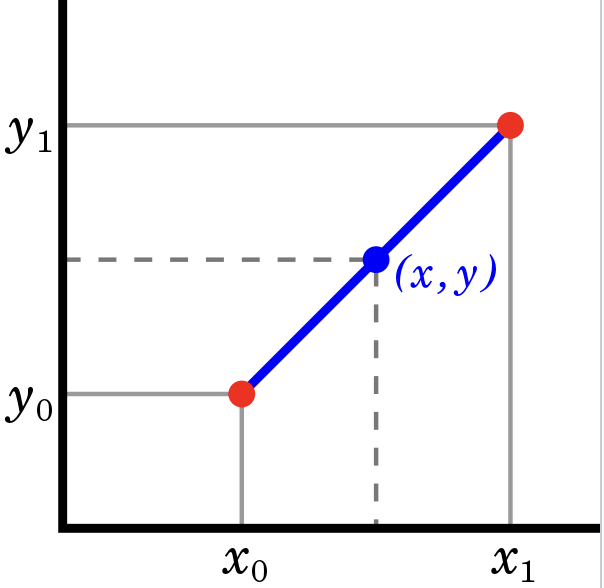

In [17]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [18]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [19]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [20]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [21]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                          0
번지                         227
본번                          75
부번                          75
아파트명                      2136
전용면적                         0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
해제사유발생일                1121899
등기신청일자                 1111271
거래유형                   1086451
중개사소재지                 1090013
단지분류                    877273
전화번호                    876850
팩스번호                    879348
단지소개clob               1058958
분양형태                    876125
관리방식                    876125
복도유형                    876454
난방방식                    876125
전체동수                    877207
전체세대수                   876125
건설사(시공사)                877637
시행사                     877834
사용승인일                   876259
연면적                     876125
주거전용면적                  876170
관리비부과면적                 876125
60㎡이하세대현황               876170
60㎡~85㎡이

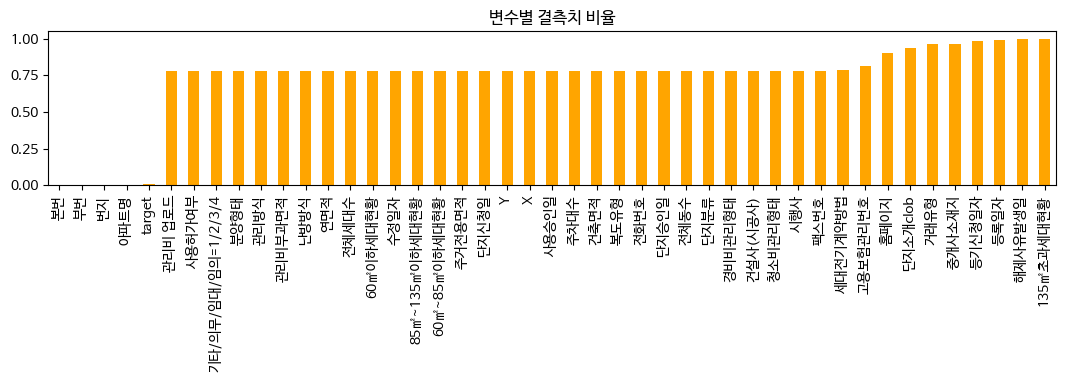

In [22]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [23]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '단지분류', '전화번호', '팩스번호', '분양형태', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사(시공사)', '시행사', '사용승인일', '연면적', '주거전용면적', '관리비부과면적', '60㎡이하세대현황', '60㎡~85㎡이하세대현황', '85㎡~135㎡이하세대현황', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', 'X', 'Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개clob', '135㎡초과세대현황', '홈페이지', '등록일자']


In [24]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [25]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                         0
번지                        227
본번                         75
부번                         75
아파트명                     2136
전용면적                        0
계약년월                        0
계약일                         0
층                           0
건축년도                        0
도로명                         0
단지분류                   877273
전화번호                   876850
팩스번호                   879348
분양형태                   876125
관리방식                   876125
복도유형                   876454
난방방식                   876125
전체동수                   877207
전체세대수                  876125
건설사(시공사)               877637
시행사                    877834
사용승인일                  876259
연면적                    876125
주거전용면적                 876170
관리비부과면적                876125
60㎡이하세대현황              876170
60㎡~85㎡이하세대현황          876170
85㎡~135㎡이하세대현황         876170
수정일자                   876170
고용보험관리번호               920757
경비비관리형태                877561
세대전기계약방법               885389
청소비관리형태   

In [26]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   시군구                  1128094 non-null  object 
 1   번지                   1127867 non-null  object 
 2   본번                   1128019 non-null  float64
 3   부번                   1128019 non-null  float64
 4   아파트명                 1125958 non-null  object 
 5   전용면적                 1128094 non-null  float64
 6   계약년월                 1128094 non-null  int64  
 7   계약일                  1128094 non-null  int64  
 8   층                    1128094 non-null  int64  
 9   건축년도                 1128094 non-null  int64  
 10  도로명                  1128094 non-null  object 
 11  단지분류                 250821 non-null   object 
 12  전화번호                 251244 non-null   object 
 13  팩스번호                 248746 non-null   object 
 14  분양형태                 251969 non-null   object 
 15  관

In [27]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [28]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '60㎡이하세대현황', '60㎡~85㎡이하세대현황', '85㎡~135㎡이하세대현황', '건축면적', '주차대수', 'X', 'Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', '단지분류', '전화번호', '팩스번호', '분양형태', '관리방식', '복도유형', '난방방식', '건설사(시공사)', '시행사', '사용승인일', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [29]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [30]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                    0
번지                     0
본번                     0
부번                     0
아파트명                   0
전용면적                   0
계약년월                   0
계약일                    0
층                      0
건축년도                   0
도로명                    0
단지분류                   0
전화번호                   0
팩스번호                   0
분양형태                   0
관리방식                   0
복도유형                   0
난방방식                   0
전체동수                   0
전체세대수                  0
건설사(시공사)               0
시행사                    0
사용승인일                  0
연면적                    0
주거전용면적                 0
관리비부과면적                0
60㎡이하세대현황              0
60㎡~85㎡이하세대현황          0
85㎡~135㎡이하세대현황         0
수정일자                   0
고용보험관리번호               0
경비비관리형태                0
세대전기계약방법               0
청소비관리형태                0
건축면적                   0
주차대수                   0
기타/의무/임대/임의=1/2/3/4    0
단지승인일                  0
사용허가여부                 0
관리비 업로드                0


- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

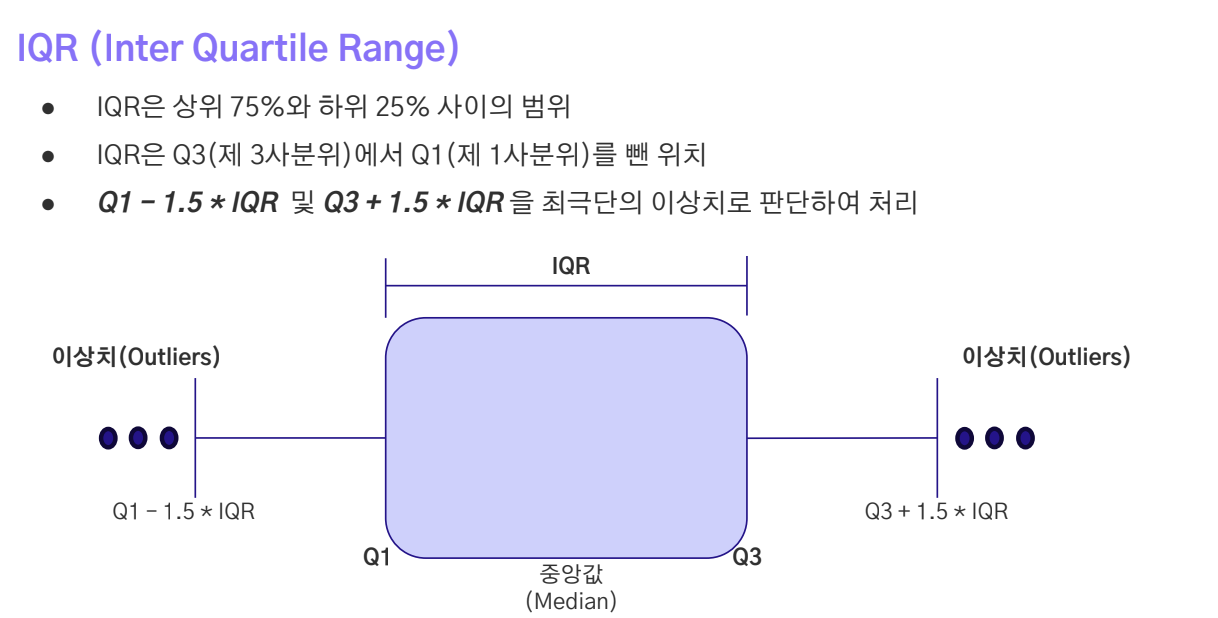

In [31]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 45)


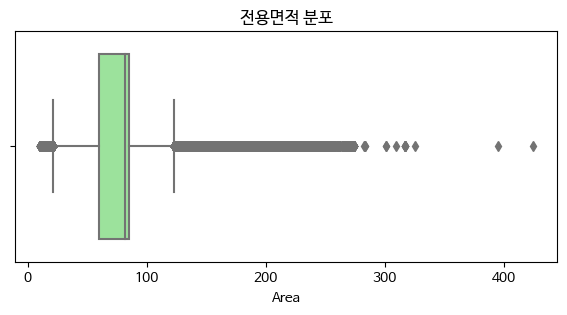

In [32]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [33]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [34]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [35]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 45)


In [36]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

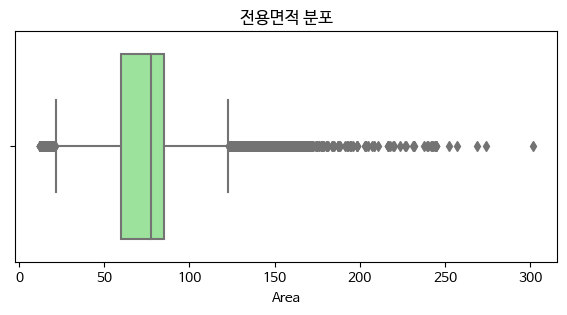

In [37]:
# 이상치 제거 후 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

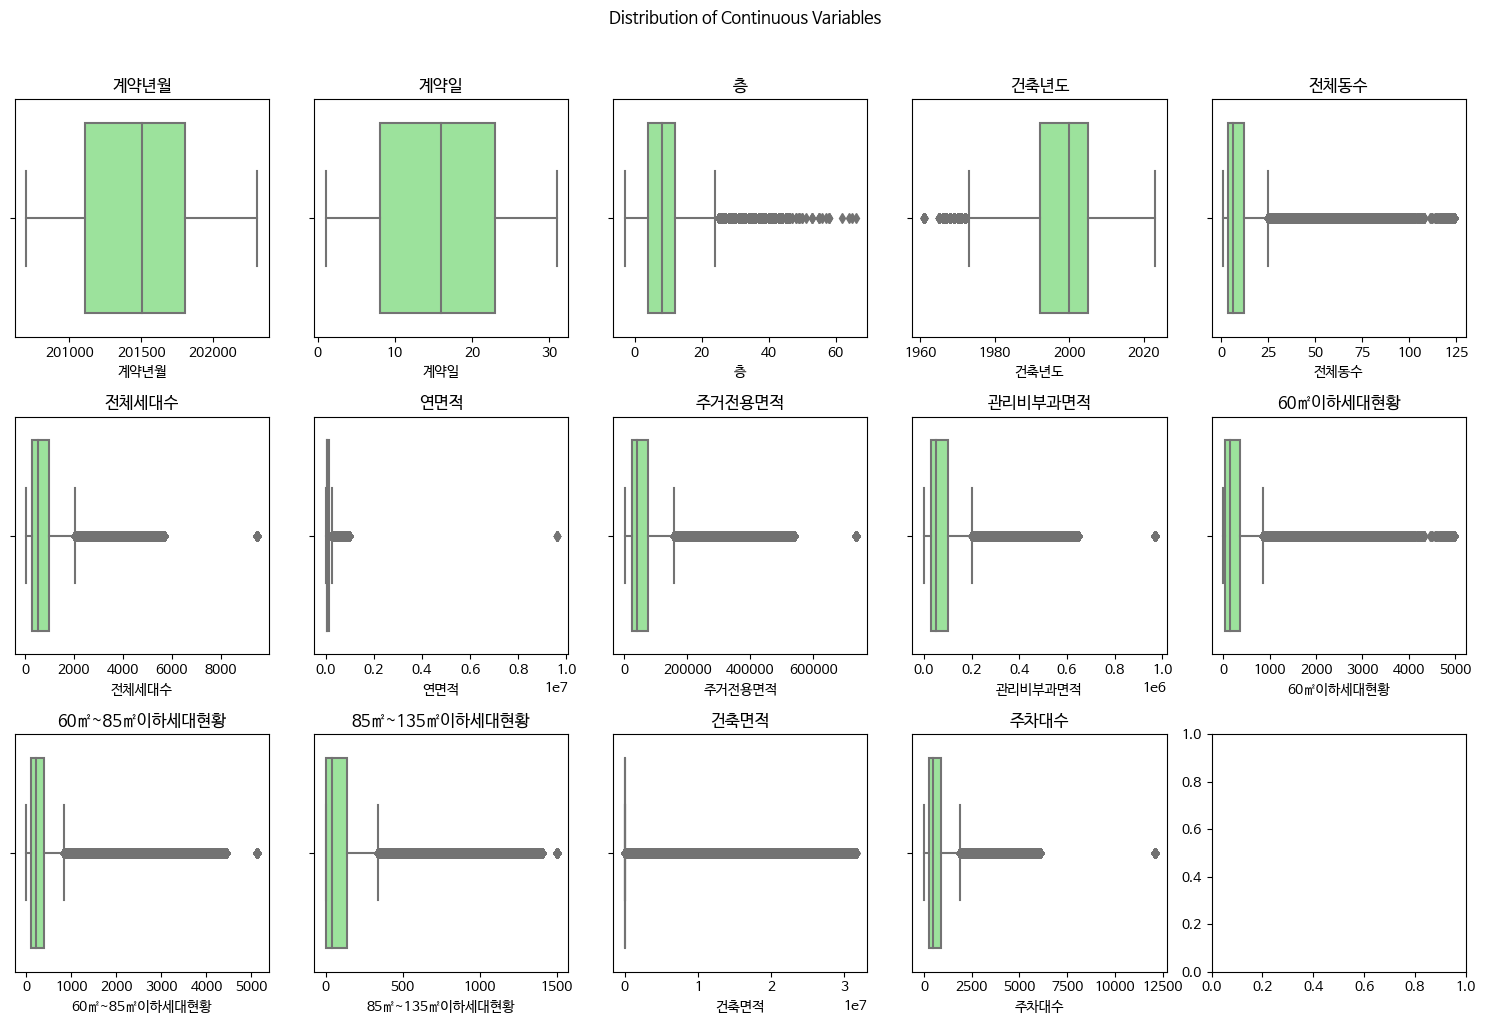

In [38]:
selected_cols = ['계약년월', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '60㎡이하세대현황', '60㎡~85㎡이하세대현황', '85㎡~135㎡이하세대현황', '건축면적', '주차대수']

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
fig.suptitle('Distribution of Continuous Variables', y=1.02)

axes = axes.flatten()

for i, column in enumerate(selected_cols):
    sns.boxplot(data=concat_select, x=column, ax=axes[i], color='lightgreen')
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
select_cols = ['건축년도', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '60㎡~85㎡이하세대현황', '85㎡~135㎡이하세대현황', '주차대수']
for col in select_cols:
    concat_select = remove_outliers_iqr(concat_select, col)

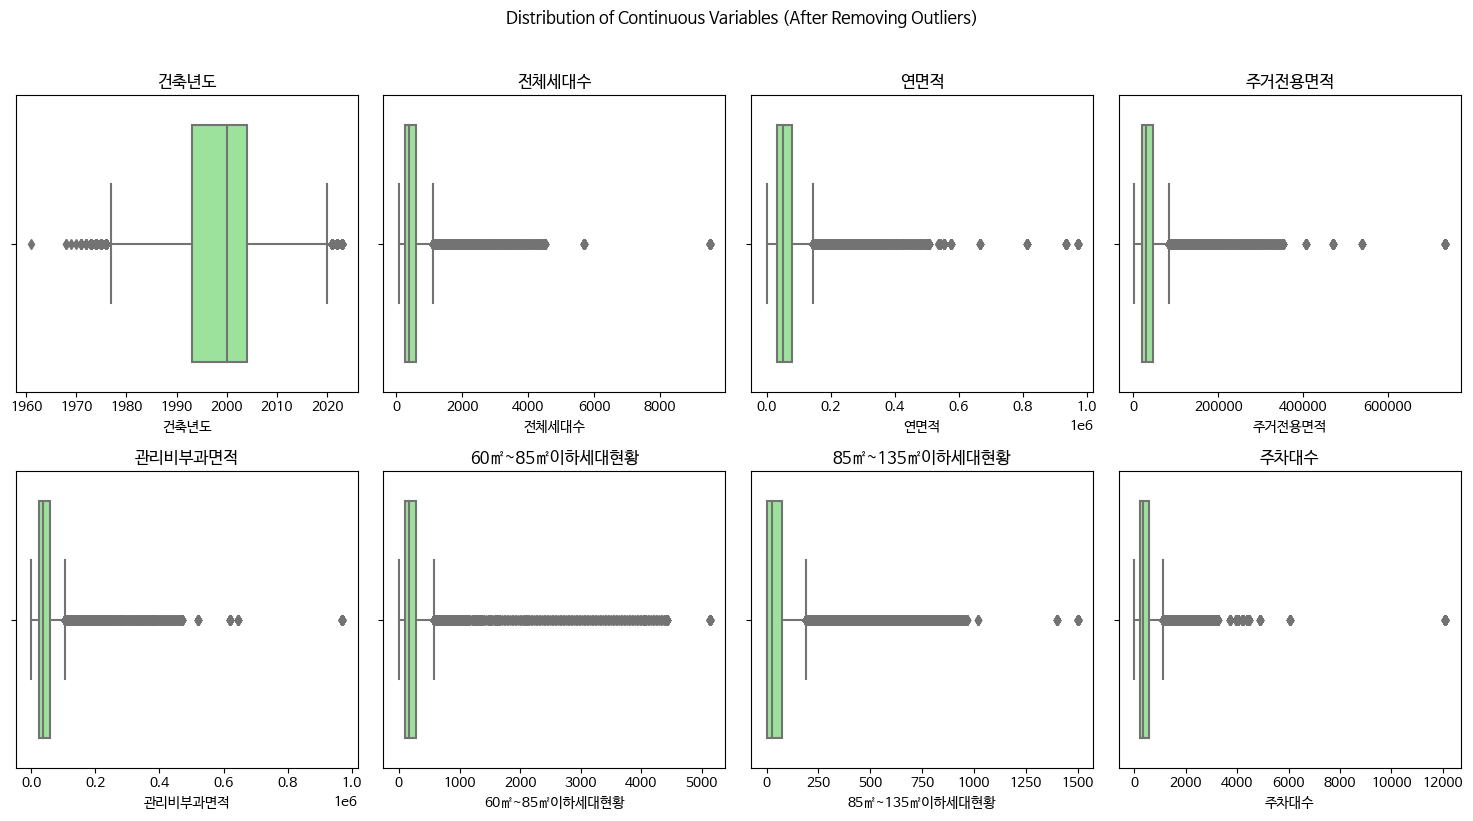

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
fig.suptitle('Distribution of Continuous Variables (After Removing Outliers)', y=1.02)

axes = axes.flatten()
for i, column in enumerate(select_cols):
    sns.boxplot(data=concat_select, x=column, ax=axes[i], color='lightgreen')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [41]:
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0


In [42]:
for col in concat_select.columns:
    missing_values = concat_select[col].isnull().sum()
    print(f"{col} 열 결측치 개수: {missing_values}")

시군구 열 결측치 개수: 0
번지 열 결측치 개수: 0
본번 열 결측치 개수: 0
부번 열 결측치 개수: 0
아파트명 열 결측치 개수: 0
전용면적 열 결측치 개수: 0
계약년월 열 결측치 개수: 0
계약일 열 결측치 개수: 0
층 열 결측치 개수: 0
건축년도 열 결측치 개수: 0
도로명 열 결측치 개수: 0
단지분류 열 결측치 개수: 0
전화번호 열 결측치 개수: 0
팩스번호 열 결측치 개수: 0
분양형태 열 결측치 개수: 0
관리방식 열 결측치 개수: 0
복도유형 열 결측치 개수: 0
난방방식 열 결측치 개수: 0
전체동수 열 결측치 개수: 0
전체세대수 열 결측치 개수: 0
건설사(시공사) 열 결측치 개수: 0
시행사 열 결측치 개수: 0
사용승인일 열 결측치 개수: 0
연면적 열 결측치 개수: 0
주거전용면적 열 결측치 개수: 0
관리비부과면적 열 결측치 개수: 0
60㎡이하세대현황 열 결측치 개수: 0
60㎡~85㎡이하세대현황 열 결측치 개수: 0
85㎡~135㎡이하세대현황 열 결측치 개수: 0
수정일자 열 결측치 개수: 0
고용보험관리번호 열 결측치 개수: 0
경비비관리형태 열 결측치 개수: 0
세대전기계약방법 열 결측치 개수: 0
청소비관리형태 열 결측치 개수: 0
건축면적 열 결측치 개수: 0
주차대수 열 결측치 개수: 0
기타/의무/임대/임의=1/2/3/4 열 결측치 개수: 0
단지승인일 열 결측치 개수: 0
사용허가여부 열 결측치 개수: 0
관리비 업로드 열 결측치 개수: 0
X 열 결측치 개수: 0
Y 열 결측치 개수: 0
단지신청일 열 결측치 개수: 0
target 열 결측치 개수: 0
is_test 열 결측치 개수: 0


In [43]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
concat_select_path = '/data/ephemeral/home/code/outliers_done.csv'
#concat_select = pd.read_csv(concat_select_path)
#concat_select = concat_selects.drop('Unnamed: 0', axis=1)

In [44]:
for col in concat_select.columns:
    missing_values = concat_select[col].isnull().sum()
    print(f"{col} 열 결측치 개수: {missing_values}")

시군구 열 결측치 개수: 0
번지 열 결측치 개수: 0
본번 열 결측치 개수: 0
부번 열 결측치 개수: 0
아파트명 열 결측치 개수: 0
전용면적 열 결측치 개수: 0
계약년월 열 결측치 개수: 0
계약일 열 결측치 개수: 0
층 열 결측치 개수: 0
건축년도 열 결측치 개수: 0
도로명 열 결측치 개수: 0
단지분류 열 결측치 개수: 0
전화번호 열 결측치 개수: 0
팩스번호 열 결측치 개수: 0
분양형태 열 결측치 개수: 0
관리방식 열 결측치 개수: 0
복도유형 열 결측치 개수: 0


난방방식 열 결측치 개수: 0
전체동수 열 결측치 개수: 0
전체세대수 열 결측치 개수: 0
건설사(시공사) 열 결측치 개수: 0
시행사 열 결측치 개수: 0
사용승인일 열 결측치 개수: 0
연면적 열 결측치 개수: 0
주거전용면적 열 결측치 개수: 0
관리비부과면적 열 결측치 개수: 0
60㎡이하세대현황 열 결측치 개수: 0
60㎡~85㎡이하세대현황 열 결측치 개수: 0
85㎡~135㎡이하세대현황 열 결측치 개수: 0
수정일자 열 결측치 개수: 0
고용보험관리번호 열 결측치 개수: 0
경비비관리형태 열 결측치 개수: 0
세대전기계약방법 열 결측치 개수: 0
청소비관리형태 열 결측치 개수: 0
건축면적 열 결측치 개수: 0
주차대수 열 결측치 개수: 0
기타/의무/임대/임의=1/2/3/4 열 결측치 개수: 0
단지승인일 열 결측치 개수: 0
사용허가여부 열 결측치 개수: 0
관리비 업로드 열 결측치 개수: 0
X 열 결측치 개수: 0
Y 열 결측치 개수: 0
단지신청일 열 결측치 개수: 0
target 열 결측치 개수: 0
is_test 열 결측치 개수: 0


In [45]:
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0


## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [46]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [47]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '단지분류',
       '전화번호', '팩스번호', '분양형태', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수',
       '건설사(시공사)', '시행사', '사용승인일', '연면적', '주거전용면적', '관리비부과면적', '60㎡이하세대현황',
       '60㎡~85㎡이하세대현황', '85㎡~135㎡이하세대현황', '수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', 'X', 'Y', '단지신청일', 'target', 'is_test', '구', '동',
       '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [48]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [49]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [50]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '단지분류',
       '전화번호', '팩스번호', '분양형태', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수',
       '건설사(시공사)', '시행사', '사용승인일', '연면적', '주거전용면적', '관리비부과면적', '60㎡이하세대현황',
       '60㎡~85㎡이하세대현황', '85㎡~135㎡이하세대현황', '수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', 'X', 'Y', '단지신청일', 'target', 'is_test', '구', '동',
       '계약년', '계약월', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [51]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    730155.000000
mean       1998.836670
std           8.685417
min        1961.000000
10%        1987.000000
25%        1993.000000
50%        2000.000000
75%        2004.000000
80%        2006.000000
90%        2009.000000
max        2023.000000
Name: 건축년도, dtype: float64

In [52]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [53]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12,1,0


In [54]:
concat_select.shape

(730155, 49)

아파트 노후도

In [55]:
concat_select['노후도'] = 2025-concat_select['건축년도']

x,y,z

In [56]:
coslat = concat_select['X'].apply(lambda x : math.cos(x))
coslong  = concat_select['Y'].apply(lambda x : math.cos(x))
sinlat = concat_select['X'].apply(lambda x : math.sin(x))
sinlong = concat_select['Y'].apply(lambda x : math.sin(x))

concat_select['x3'] = coslat*coslong
concat_select['y3'] = coslat*sinlong
concat_select['z3'] = sinlat

도로명 주소로 좌표 얻기 https://business.juso.go.kr/addrlink/openApi/popupApi.do
<p>초등학교/중학교/고등학교(가장 가까운) + 거리 https://developers.kakao.com/docs/latest/ko/local/dev-guide </p>
<p>사설학원(2km이내 학원수)(https://developers.kakao.com/docs/latest/ko/local/dev-guide)</p>
<p>고교별 수능 국수 평균 백분위(https://cafe.naver.com/we2you/6167)</p>

고등학교

In [52]:
def get_nearest_highschool(api_key, x, y, n):
    # Kakao Maps API 호출을 위한 기본 설정
    base_url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}

    # Kakao Maps API에 요청
    query = "고등학교"  # 추가: "고등학교" 키워드를 검색어에 추가
    response = requests.get(base_url, headers=headers, params={"query": query, "x": x, "y": y, "sort": "distance"})
    data = response.json()

    # 응답 데이터에서 가장 가까운 고등학교 정보 추출
    highschool_info = data.get("documents", [])

    # SC4 카테고리인 경우 place_name과 distance를 반환, 아닌 경우 패스
    sc4_highschool_data = [(school['place_name'], school.get('distance', '')) for school in highschool_info if 'SC4' in school.get('category_group_code', '')][:n]

    return sc4_highschool_data

# Kakao Maps API 키 설정
api_key = ""

# 도로명 주소에서 가장 가까운 고등학교 검색 및 결과 추가
concat_select['고등학교'] = concat_select.apply(lambda row: get_nearest_highschool(api_key, row['X'], row['Y'], 3), axis=1)

# Extract distance for the first school and create a new column
concat_select['고등학교 거리'] = concat_select['고등학교'].apply(lambda x: x[0][1] if x else '')
concat_select['고등학교'] = concat_select['고등학교'].apply(lambda schools: [school[0] for school in schools])

concat_select.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교,고등학교 거리
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12,1,0,38,0.172023,-0.038892,0.984325,"[국립국악고등학교, 개포고등학교, 수도전기공업고등학교]",521
1,658-1,658.0,1.0,개포6차우성,79.97,22,4,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0,강남구,개포동,2017,12,1,0,38,0.172023,-0.038892,0.984325,"[국립국악고등학교, 개포고등학교, 수도전기공업고등학교]",521
2,658-1,658.0,1.0,개포6차우성,54.98,28,5,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0,강남구,개포동,2017,12,1,0,38,0.172023,-0.038892,0.984325,"[국립국악고등학교, 개포고등학교, 수도전기공업고등학교]",521
3,658-1,658.0,1.0,개포6차우성,79.97,3,4,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0,강남구,개포동,2018,01,1,0,38,0.172023,-0.038892,0.984325,"[국립국악고등학교, 개포고등학교, 수도전기공업고등학교]",521
4,658-1,658.0,1.0,개포6차우성,79.97,8,2,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0,강남구,개포동,2018,01,1,0,38,0.172023,-0.038892,0.984325,"[국립국악고등학교, 개포고등학교, 수도전기공업고등학교]",521


In [ ]:
concat_select

In [31]:
schools = [
    "서울11407 하나고등학교",    "서울11184 세화고등학교",    "서울11218 휘문고등학교",    "서울11267 세화여자고등학교",
    "서울11335 보인고등학교",    "서울11180 선덕고등학교",    "서울11503 대원외국어고등학교",    "서울11269 숙명여자고등학교",
    "서울11147 강서고등학교",    "서울11205 중동고등학교",    "서울11219 중산고등학교",    "서울11504 대일외국어고등학교",
    "서울11159 단국사대부속고등학교",    "서울11272 목동고등학교",    "서울11505 명덕외국어고등학교",    "서울11582 서울국제고등학교",
    "서울11507 한영외국어고등학교",    "서울11189 양정고등학교",    "서울11221 한가람고등학교",    "서울11287 진선여자고등학교",
    "서울11175 배재고등학교",    "서울11202 장훈고등학교",    "서울11506 이화여자외국어고등학교",    "서울11103 경기고등학교",
    "서울11139 잠신고등학교",    "서울11231 경기여자고등학교",    "서울11280 이화여자고등학교",    "서울11206 중앙고등학교",
    "서울11191 영동고등학교",    "서울11160 대광고등학교",    "서울11291 한양사대부속고등학교",    "서울11263 서문여자고등학교",
    "서울11247 대진여자고등학교",    "서울11214 현대고등학교",    "서울11286 진명여자고등학교",    "서울11165 대진고등학교",
    "서울11118 반포고등학교",    "서울11199 이화여대부속이화:금란고등학교",    "서울11282 정신여자고등학교",    "서울11281 잠실여자고등학교",
    "서울11177 상문고등학교",    "서울11279 은광여자고등학교",    "서울11274 영동일고등학교",    "서울11270 숭의여자고등학교",
    "서울11203 재현고등학교",
    "서울11109 광남고등학교",    "서울11188 신일고등학교",    "서울11204 중앙사대부속고등학교",    "서울11164 대일고등학교",
    "서울11502 한성과학고등학교",    "서울11186 숭문고등학교",    "서울11170 명덕고등학교",    "서울11169 마포고등학교",
    "서울11121 서울고등학교",    "서울11190 양천고등학교",    "서울11213 한영고등학교",    "서울11253 명덕여자고등학교",
    "서울11176 보성고등학교",    "서울11278 용화여자고등학교",    "서울11102 개포고등학교",    "서울11136 용산고등학교",
    "서울11295 휘경여자고등학교",    "서울11262 상일여자고등학교",    "서울11584 구현고등학교",    "서울11508 서울외국어고등학교",
    "서울11128 신목고등학교",    "서울11152 경희고등학교",    "서울11161 대성고등학교",    "서울11237 여의도여자고등학교",
    "서울11275 영신여자고등학교",    "서울11262 상일여자고등학교",    "서울11277 예일여자고등학교",    "서울11580 원묵고등학교",
    "서울11250 동덕여자고등학교",    "서울11178 서라벌고등학교",    "서울11243 계성고등학교",    "서울11239 창덕여자고등학교",
    "서울11131 여의도고등학교",    "서울11265 성신여자고등학교",    "서울11256 서울문영여자고등학교",    "서울11129 양재고등학교",
    "서울11182 성남고등학교",    "서울11249 덕원여자고등학교",    "서울11252 동일여자고등학교",    "서울11140 잠실고등학교",
    "서울11296 경복여자고등학교",    "서울11591 신도림고등학교",    "서울11198 백암고등학교",    "서울11266 성심여자고등학교",
    "서울11420 잠일고등학교",    "서울11316 동양고등학교",    "서울11130 언남고등학교",    "서울11123 서초고등학교",
    "서울11257 미림여자고등학교",    "서울11149 경문고등학교",    "서울11289 풍문고등학교",    "서울11217 환일고등학교",
    "서울11293 혜원여자고등학교",    "서울11143 청담고등학교",    "서울11234 무학여자고등학교",    "서울11200 인창고등학교",
    "서울11179 서울세종고등학교",    "서울11261 상명사대부속여자고등학교",    "서울11113 압구정고등학교",    "서울11258 배화여자고등학교",
    "서울11285 중앙여자고등학교",    "서울11254 동국사대부속여자고등학교",    "서울11236 수도여자고등학교",    "서울11235 서울여자고등학교",
    "서울11292 혜성여자고등학교",    "서울11288 창문여자고등학교",
    "서울11404 서울예술고등학교",    "서울11294 홍익사대부속여자고등학교",    "서울11154 광문고등학교",    "서울11276 영파여자고등학교",
    "서울11173 배명고등학교",    "서울11232 금옥여자고등학교",    "서울11195 오산고등학교",    "서울11586 해성여자고등학교",
    "서울11264 선일여자고등학교",    "서울11172 문일고등학교",    "서울11383 청원여자고등학교",    "서울11193 영일고등학교",
    "서울11211 한서고등학교",    "서울11196 용문고등학교",    "서울11389 방산고등학교",    "서울11283 정의여자고등학교",
    "서울11395 선유고등학교",    "서울11158 남강고등학교",    "서울11183 성보고등학교",    "서울11101 가락고등학교",
    "서울11148 건국사대부속고등학교",    "서울11155 광성고등학교",    "서울11233 명일여자고등학교",    "서울11248 덕성여자고등학교",
    "서울11216 화곡고등학교",    "서울11251 동명여자고등학교",    "서울11181 선정고등학교",    "서울11168 동성고등학교",
    "서울11397 불암고등학교",    "서울11167 동북고등학교",    "서울11108 관악고등학교",    "서울11394 경일고등학교",
    "서울11399 강일고등학교",    "서울11151 경신고등학교",    "서울11242 경희여자고등학교",    "서울11421 구암고등학교",
    "서울11238 영등포여자고등학교",    "서울11207 청원고등학교",    "서울11220 둔촌고등학교",    "서울11162 대신고등학교",
    "서울11210 한국삼육고등학교",    "서울11246 대원여자고등학교",    "서울11331 대동세무고등학교",    "서울11138 자양고등학교",
    "서울11290 한성여자고등학교",    "서울11116 동작고등학교",    "서울11197 우신고등학교",    "서울11382 오류고등학교",
    "서울11393 등촌고등학교",    "서울11174 배문고등학교",    "서울11240 혜화여자고등학교",    "서울11156 광신고등학교",
    "서울11141 중경고등학교",    "서울11171 명지고등학교",   "서울11125 성동고등학교",    "서울11405 선화예술고등학교",
    "서울11187 숭실고등학교",    "서울11117 면목고등학교",    "서울11120 상계고등학교",    "서울11244 광영여자고등학교",
    "서울11589 성수고등학교",    "서울11112 구일고등학교",    "서울11212 한성고등학교",    "서울11400 문현고등학교",
    "서울11132 영등포고등학교",    "서울11146 강동고등학교",
    "서울11593 진관고등학교",    "서울11201 장충고등학교",    "서울11110 광양고등학교",    "서울11215 홍익사대부속고등학교",
    "서울11114 당곡고등학교",    "서울11135 노원고등학교",    "서울11105 경복고등학교",    "서울11387 창동고등학교",
    "서울11166 동국대사대부속고등학교",    "서울11384 경인고등학교",    "서울11352 성덕고등학교",    "서울11585 문정고등학교",
    "서울11388 누원고등학교",    "서울11259 보성여자고등학교",    "서울11194 영훈고등학교",    "서울11392 도봉고등학교",
    "서울11576 세현고등학교",    "서울11312 선린인터넷고등학교",    "서울11581 상암고등학교",    "서울11134 오금고등학교",
    "서울11137 인헌고등학교",    "서울11145 태릉고등학교",    "서울11314 단국대학교부속소프트웨어고등학교",    "서울11271 신광여자고등학교",
    "서울11577 신서고등학교",    "서울11208 충암고등학교",    "서울11260 상명고등학교",    "서울11122 서울사대부설고등학교",
    "서울11390 신현고등학교",    "서울11107 공항고등학교",    "서울11153 고려사대부속고등학교",    "서울11396 월계고등학교",
    "서울11115 대영고등학교",    "서울11150 경성고등학교",    "서울11595 가재울고등학교",    "서울11597 금호고등학교",
    "서울11111 구로고등학교",    "서울11192 영락고등학교",    "서울11127 신림고등학교",    "서울11163 대원고등학교",
    "서울11412 선사고등학교",    "서울11106 고척고등학교",    "서울11119 삼성고등학교",    "서울11124 석관고등학교",
    "서울11273 염광고등학교",    "서울11596 도선고등학교",    "서울11144 청량고등학교",    "서울11411 신도고등학교",
    "서울11391 자운고등학교",    "서울11419 휘봉고등학교",    "서울11386 수락고등학교",    "서울11133 영신고등학교",
    "서울11578 효문고등학교",    "서울11340 미래산업과학고등학교",    "서울11592 은평고등학교",    "서울11402 덕원예술고등학교",
    "서울11588 미양고등학교",    "서울11185 송곡고등학교",    "서울11126 금천고등학교",    "서울11376 서울미술고등학교",
    "서울11157 광영고등학교",    "서울11590 수명고등학교",    "서울11268 송곡여자고등학교",    "서울11142 중화고등학교",
    "서울11413 삼각산고등학교",    "서울11104 경동고등학교",
    "서울11361 해성국제컨벤션고등학교",    "서울11385 독산고등학교",    "서울11355 서울영상고등학교",    "서울11369 예일디자인고등학교",
    "서울11356 이화여대병설미디어고등학교",    "서울11344 경복비즈니스고등학교",    "서울11371 대진디자인고등학교",    "서울11308 경기상업고등학교",
    "서울11353 성암국제무역고등학교",    "서울11350 서울여자상업고등학교",    "서울11342 염광여자메디텍고등학교",    "서울11209 한광고등학교",
    "서울11360 서울공연예술고등학교",    "서울11310 덕수고등학교"

]

scores = [
    88.71, 84.64, 84.12, 84.06, 83.83, 83.2, 82.7, 82.67, 82.58, 81.65,
    81.15, 80.8, 80.52, 80.43, 79.62, 79.59, 79.42, 78.25, 78.11, 77.56,
    76.86, 76.83, 76.06, 75.58, 75.57, 75.52, 75.46, 75.13, 75.03, 74.79,
    74.69, 73.79, 73.7, 73.4, 73.18, 73.06, 72.72, 72.71, 72.43, 72.38,
    72.28, 71.45, 70.6, 70.55, 70.06,
    69.98, 69.63, 68.92, 68.73, 68.73, 68.71, 68.64, 68.54, 68.31,
    68.19, 67.95, 67.93, 67.91, 67.82, 67.66, 67.66, 67.27, 67.14,
    66.97, 66.76, 66.18, 66.12, 66.11, 65.6, 65.59, 65.51, 65.51,
    65.48, 65.35, 65.34, 65.03, 64.78, 64.77, 64.72, 64.26, 64.23,
    64.09, 64, 63.95, 63.85, 63.75, 63.27, 63.19, 62.82, 62.62, 62.21,
    62.1, 61.95, 61.73, 61.45, 61.43, 61.39, 61.21, 61.17, 61.05, 60.81,
    60.68, 60.43, 60.12, 60.1, 60.04, 60, 59.85, 59.72, 59.62, 59.6,
    59.44, 59.4, 59.25, 59.23, 59.16, 58.95, 58.91, 58.9, 58.89, 58.63,
    58.62, 58.5, 58.46, 58.34, 58.22, 58.09, 58.0, 57.97, 57.82, 57.75,
    57.63, 57.51, 57.41, 57.35, 57.12, 57.07, 56.84, 56.83, 56.7, 56.69,
    56.64, 56.56, 56.23, 56.12, 56.03, 55.96, 55.78, 55.77, 55.4, 55.23,
    54.9, 54.9, 54.86, 54.79, 54.77, 54.45, 54.14, 54.05, 54.03, 53.68,
    53.67, 53.66, 53.45, 53.39, 53.3, 53.16, 53.09, 53.08, 52.95, 52.75,
    52.71, 52.59, 52.12, 52.06, 51.98, 51.92,
    51.74, 51.66, 51.61, 51.61, 51.58, 51.47, 51.37, 51.32, 51.24, 50.9,
    50.62, 50.58, 50.54, 50.53, 50.47, 50.41, 50.12, 50.1, 50.1, 50.03,
    49.99, 49.91, 49.77, 49.65, 49.5, 49.48, 49.37, 49.34, 49.01, 48.92,
    48.9, 48.85, 48.73, 48.52, 48.42, 48.24, 47.98, 47.92, 47.85, 47.83,
    47.5, 47.4, 47.37, 46.98, 46.93, 46.81, 46.71, 46.19, 46.13, 45.92,
    45.87, 45.71, 45.44, 44.85, 44.81, 44.74, 44.68, 43.92, 43.46, 43.4,
    43.31, 43.22, 43.1, 42.54, 40.76, 40.54, 40.02, 39.96, 37.22, 35.41,
    35.38, 35.19, 32.7, 31.75, 30.67, 30.58, 23.54, 21.52, 20.59, 19.78
]

score_df = pd.DataFrame({'학교': schools, '점수': scores})

score_df['학교'] = score_df['학교'].apply(lambda x: x.split()[-1])
score_df.head()

,학교,점수
0,하나고등학교,88.71
1,세화고등학교,84.64
2,휘문고등학교,84.12
3,세화여자고등학교,84.06
4,보인고등학교,83.83


In [53]:
concat_select['학군점수'] = concat_select['고등학교'].apply(lambda schools: sum(score_df[score_df['학교'].isin(schools)]['점수']) / len(schools) if schools else None)

In [54]:
concat_select.to_csv('highschoolscore_done.csv')

In [57]:
concat_select_path = '/data/ephemeral/home/code/highschoolscore_done.csv'
score = pd.read_csv(concat_select_path)
score = score[['고등학교 거리','학군점수']]

In [149]:
concat_select.shape

(730155, 53)

In [58]:
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12,1,0,38,0.172023,-0.038892,0.984325


In [151]:
score.head(1)

,고등학교 거리,학군점수
0,521.0,22.553333


In [152]:
score.shape

(730155, 2)

In [59]:
concat_select['고등학교 거리'] = score['고등학교 거리']

In [60]:
concat_select['학군점수'] = score['학군점수']

In [61]:
for col in concat_select.columns:
    missing_values = concat_select[col].isnull().sum()
    print(f"{col} 열 결측치 개수: {missing_values}")

번지 열 결측치 개수: 0
본번 열 결측치 개수: 0
부번 열 결측치 개수: 0
아파트명 열 결측치 개수: 0
전용면적 열 결측치 개수: 0
계약일 열 결측치 개수: 0
층 열 결측치 개수: 0
건축년도 열 결측치 개수: 0
도로명 열 결측치 개수: 0
단지분류 열 결측치 개수: 0
전화번호 열 결측치 개수: 0
팩스번호 열 결측치 개수: 0
분양형태 열 결측치 개수: 0
관리방식 열 결측치 개수: 0
복도유형 열 결측치 개수: 0
난방방식 열 결측치 개수: 0
전체동수 열 결측치 개수: 0
전체세대수 열 결측치 개수: 0
건설사(시공사) 열 결측치 개수: 0
시행사 열 결측치 개수: 0
사용승인일 열 결측치 개수: 0
연면적 열 결측치 개수: 0
주거전용면적 열 결측치 개수: 0
관리비부과면적 열 결측치 개수: 0
60㎡이하세대현황 열 결측치 개수: 0
60㎡~85㎡이하세대현황 열 결측치 개수: 0
85㎡~135㎡이하세대현황 열 결측치 개수: 0
수정일자 열 결측치 개수: 0
고용보험관리번호 열 결측치 개수: 0
경비비관리형태 열 결측치 개수: 0
세대전기계약방법 열 결측치 개수: 0
청소비관리형태 열 결측치 개수: 0
건축면적 열 결측치 개수: 0
주차대수 열 결측치 개수: 0
기타/의무/임대/임의=1/2/3/4 열 결측치 개수: 0
단지승인일 열 결측치 개수: 0
사용허가여부 열 결측치 개수: 0
관리비 업로드 열 결측치 개수: 0
X 열 결측치 개수: 0
Y 열 결측치 개수: 0
단지신청일 열 결측치 개수: 0
target 열 결측치 개수: 0
is_test 열 결측치 개수: 0
구 열 결측치 개수: 0
동 열 결측치 개수: 0
계약년 열 결측치 개수: 0
계약월 열 결측치 개수: 0
강남여부 열 결측치 개수: 0
신축여부 열 결측치 개수: 0
노후도 열 결측치 개수: 0
x3 열 결측치 개수: 0
y3 열 결측치 개수: 0
z3 열 결측치 개수: 0
고등학교 거리 열 결측치 개수: 606037
학군점수 열 결측치 개수: 606037


In [62]:
concat_select = concat_select.groupby('구').apply(lambda group: group.fillna(group.mean())).reset_index(drop=True)

In [63]:
concat_select.tail(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수
730154,538,538.0,0.0,신영,16.93,18,4,2013,면목로69길 16,NULL,NULL,NULL,NULL,NULL,NULL,NULL,4.901163,524.912791,NULL,NULL,NULL,76069.063953,38075.494186,37758.0,190.116279,316.482558,18.313953,NULL,NULL,NULL,NULL,NULL,1263.33314,598.709302,NULL,NULL,NULL,NULL,127.116324,37.522414,NULL,13250.0,1,중랑구,면목동,2023,07,0,1,12,0.116067,-0.020725,0.993025,301.0,55.826667


용적률

경사도(아파트 단지로부터 400m내 평균 경사도) 국가공간정보포털(한국국토정보공사, n.d.)

NDVI(정규식생지수) 아파트 단지로부터 400m 내 평균 ndvi(미국 지질조사원)

공원(가장 가까운)
하천(가장 가까운)
한강

상가 까지의 거리

지하철역까지의 거리(가장 가까운), 지하철역 호선 개수

In [99]:
subway_df = pd.read_csv('/data/ephemeral/home/subway_feature.csv')
concat_select['지하철역까지의 거리'] = 0.0
concat_select['지하철 호선 개수'] = 0

for idx, row in concat_select.iterrows():
    property_location = (row['Y'], row['X'])
    
    # Filter subway stations based on latitude and longitude
    filtered_subway_df = subway_df[
        (subway_df['위도'] >= property_location[0] - 0.1) & (subway_df['위도'] <= property_location[0] + 0.1) &
        (subway_df['경도'] >= property_location[1] - 0.1) & (subway_df['경도'] <= property_location[1] + 0.1)
    ]
    
    min_distance = float('inf')
    closest_station_info = None
    
    for _, station_row in filtered_subway_df.iterrows():
        station_location = (station_row['위도'], station_row['경도'])
        distance = geodesic(property_location, station_location).km
        
        if distance < min_distance:
            min_distance = distance
            closest_station_info = {
                '역사명': station_row['역사명'],
                '호선': station_row['호선']
            }

    concat_select.at[idx, '지하철역까지의 거리'] = min_distance
    if closest_station_info:
        concat_select.at[idx, '지하철 호선 개수'] = filtered_subway_df[filtered_subway_df['역사명'] == closest_station_info['역사명']]['호선'].nunique()


In [98]:
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리,지하철역까지의 거리,지하철 호선 개수
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12,1,0,38,0.172023,-0.038892,0.984325,521.0,22.553333,20171208,1.5,1.127738,1


버스정류장까지의 거리(마을버스 여부/정류장 타입)

체육시설(2km 이내, 공공데이터포털)

의료시설(2km 이내, 공공데이터포털)

kospi

한국은행 기준금리

In [2]:
base_rate_data = [
    (20230113, 3.50), (20221124, 3.25), (20221012, 3.00), (20220825, 2.50),
    (20220713, 2.25), (20220526, 1.75), (20220414, 1.50), (20220114, 1.25),
    (20211125, 1.00), (20210826, 0.75), (20200528, 0.50), (20200317, 0.75),
    (20191016, 1.25), (20190718, 1.50), (20181130, 1.75), (20171130, 1.50),
    (20160609, 1.25), (20150611, 1.50), (20150312, 1.75), (20141015, 2.00),
    (20140814, 2.25), (20130509, 2.50), (20121011, 2.75), (20120712, 3.00),
    (20110610, 3.25), (20110310, 3.00), (20110113, 2.75), (20101116, 2.50),
    (20100709, 2.25), (20090212, 2.00), (20090109, 2.50), (20081211, 3.00),
    (20081107, 4.00), (20081027, 4.25), (20081009, 5.00), (20080807, 5.25),
    (20070809, 5.00), (20070712, 4.75), (20060810, 4.50), (20060608, 4.25),
    (20060209, 4.00), (20051208, 3.75), (20051011, 3.50), (20041111, 3.25),
    (20040812, 3.50), (20030710, 3.75), (20030513, 4.00), (20020507, 4.25),
    (20010919, 4.00), (20010809, 4.50), (20010705, 4.75), (20010208, 5.00),
    (20001005, 5.25), (20000210, 5.00), (19990506, 4.75)
]

base_rate_dict = {date: rate for date, rate in base_rate_data}

In [65]:
concat_select['계약년월일'] = (
    concat_select['계약년'].astype(int) * 10000 +
    concat_select['계약월'].astype(int) * 100 +
    concat_select['계약일'].astype(int)
)

for idx, row in concat_select.iterrows():
    contract_date = row['계약년월일']
    
    selected_date = max(date for date in base_rate_dict.keys() if date <= contract_date)
    
    concat_select.at[idx, '한국은행 기준금리'] = base_rate_dict[selected_date]



In [66]:
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12,1,0,38,0.172023,-0.038892,0.984325,521.0,22.553333,20171208,1.5


- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [67]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(720883, 56) (9272, 56)


In [68]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리
1,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,13250.0,강남구,개포동,2023,07,1,0,38,0.172023,-0.038892,0.984325,521.0,22.553333,20230726,3.5


In [69]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

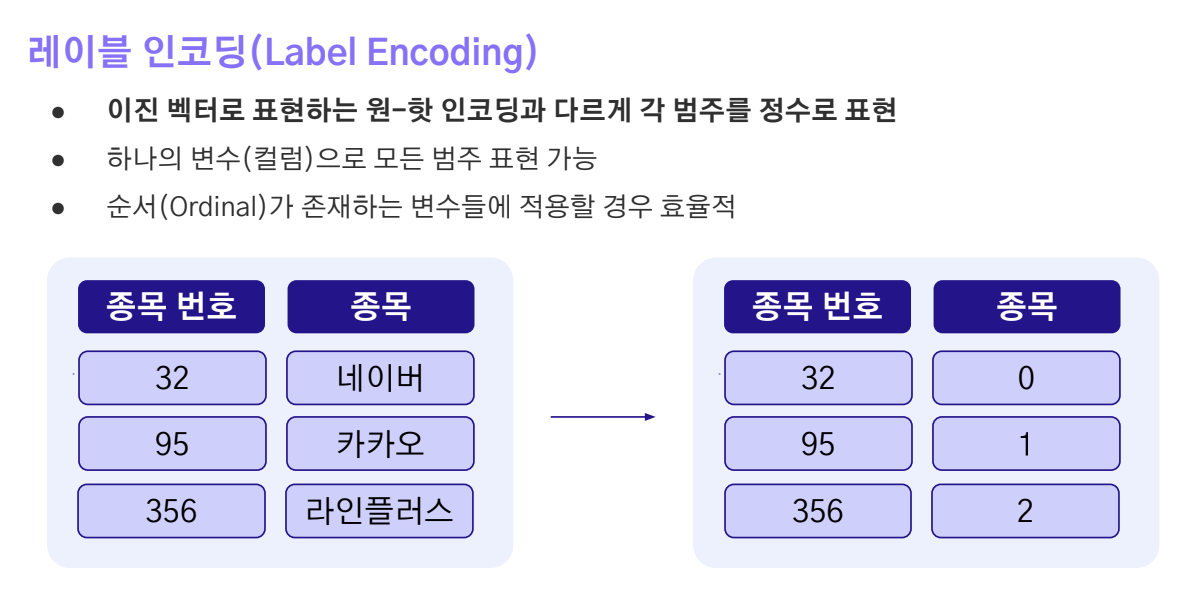

In [70]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '60㎡이하세대현황', '60㎡~85㎡이하세대현황', '85㎡~135㎡이하세대현황', '건축면적', '주차대수', 'X', 'Y', 'target', '강남여부', '신축여부', '노후도', 'x3', 'y3', 'z3', '고등학교 거리', '학군점수', '계약년월일', '한국은행 기준금리']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '전화번호', '팩스번호', '분양형태', '관리방식', '복도유형', '난방방식', '건설사(시공사)', '시행사', '사용승인일', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '구', '동', '계약년', '계약월']


In [71]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

 21%|██        | 6/29 [00:01<00:06,  3.29it/s]

100%|██████████| 29/29 [00:05<00:00,  5.27it/s]


In [72]:
for col in categorical_columns_v2:
    missing_values = concat_select[col].isnull().sum()
    print(f"{col} 열 결측치 개수: {missing_values}")

번지 열 결측치 개수: 0
본번 열 결측치 개수: 0
부번 열 결측치 개수: 0
아파트명 열 결측치 개수: 0
도로명 열 결측치 개수: 0
단지분류 열 결측치 개수: 0
전화번호 열 결측치 개수: 0
팩스번호 열 결측치 개수: 0
분양형태 열 결측치 개수: 0
관리방식 열 결측치 개수: 0
복도유형 열 결측치 개수: 0
난방방식 열 결측치 개수: 0


건설사(시공사) 열 결측치 개수: 0
시행사 열 결측치 개수: 0
사용승인일 열 결측치 개수: 0
수정일자 열 결측치 개수: 0
고용보험관리번호 열 결측치 개수: 0
경비비관리형태 열 결측치 개수: 0
세대전기계약방법 열 결측치 개수: 0
청소비관리형태 열 결측치 개수: 0
기타/의무/임대/임의=1/2/3/4 열 결측치 개수: 0
단지승인일 열 결측치 개수: 0
사용허가여부 열 결측치 개수: 0
관리비 업로드 열 결측치 개수: 0
단지신청일 열 결측치 개수: 0
구 열 결측치 개수: 0
동 열 결측치 개수: 0
계약년 열 결측치 개수: 0
계약월 열 결측치 개수: 0


In [73]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리
0,4112,1086,1,273,79.97,8,3,1987,5243,3,347,311,2,2,1,1,8.0,270.0,204,167,15,22637.0,20204.0,22637.0,20.0,250.0,0.0,139,408,4,1,4,4858.0,262.0,4,543,1,0,127.05721,37.476763,173,124000.0,0,8,10,11,1,0,38,0.172023,-0.038892,0.984325,521.0,22.553333,20171208,1.5


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [74]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [75]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [76]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
'''model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)'''
# Replace RandomForestRegressor with LGBMRegressor
model = LGBMRegressor(n_estimators=100, objective='rmse', learning_rate=0.01, max_depth=5)

model.fit(X_train, y_train)
pred = model.predict(X_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8455
[LightGBM] [Info] Number of data points in the train set: 576706, number of used features: 55
[LightGBM] [Info] Start training from score 49558.448036


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [77]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 20757.618775226798


- 변수 중요도도 확인해보도록 하겠습니다.

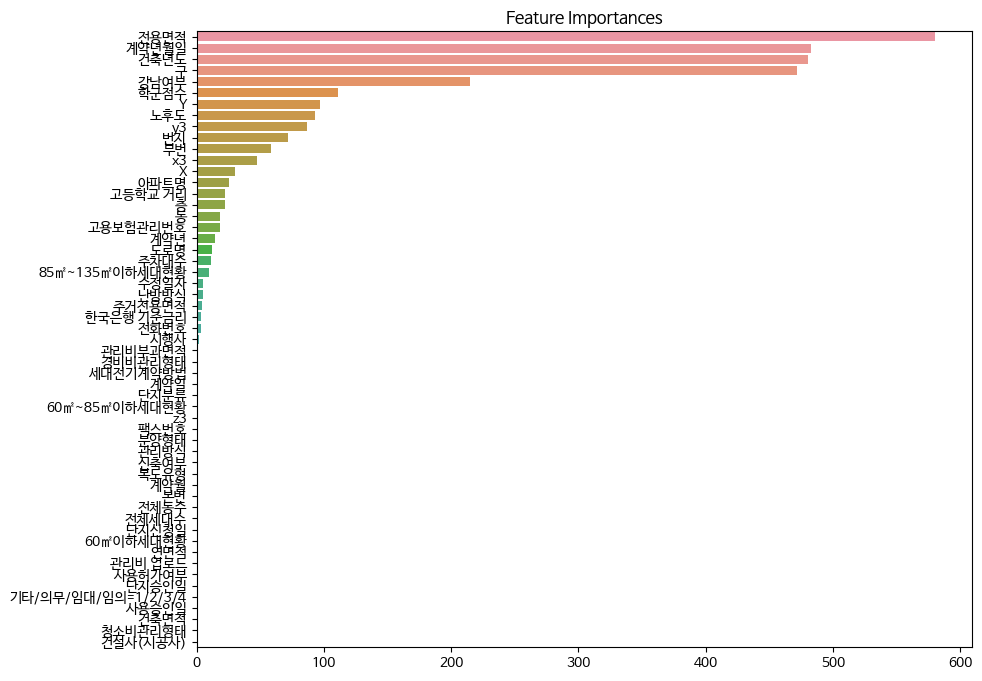

In [78]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [79]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [80]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

Weight,Feature
351502590.3407 ± 1073374.4225,계약년월일
243288934.7088 ± 5824161.7460,전용면적
91154964.4396 ± 1129580.8286,구
80239207.4328 ± 1487766.4897,강남여부
59488603.6229 ± 832421.4046,건축년도
12476889.7434 ± 142011.5959,Y
9175481.9676 ± 53662.9667,노후도
8212196.6383 ± 425344.0989,x3
5340003.8051 ± 84509.4711,학군점수
4633711.7633 ± 20701.7851,y3


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [81]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [82]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [83]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [84]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리,target,pred,error
152691,4677,1195,0,1934,107.47,20,5,1973,4763,0,827,1023,0,0,0,0,5.267123,831.969178,63,48,507,102339.345890,66354.407534,66831.263699,185.078767,596.359589,46.544521,556,408,0,0,0,195.731507,734.198630,0,550,0,1,127.016858,37.599940,180,14,106,15,5,1,0,52,0.214869,-0.021379,0.976409,540.462254,36.020739,20220620,1.75,565000.0,166008.475121,1.591942e+11
152364,4677,1195,0,1934,107.47,28,5,1973,4763,0,827,1023,0,0,0,0,3.028140,239.177763,63,48,507,33466.333562,18620.006863,23886.268360,65.424159,172.817433,0.233356,556,408,0,0,0,20.012766,253.997941,0,550,0,1,126.997210,37.504102,180,14,106,14,9,1,0,52,0.230616,-0.045551,0.971978,540.462254,36.020739,20211028,0.75,560000.0,170934.539129,1.513719e+11
152460,1075,411,0,3112,114.94,28,8,2018,6351,3,328,294,1,1,1,4,7.000000,607.000000,54,181,471,111291.000000,51475.000000,69777.000000,162.000000,291.000000,148.000000,110,408,2,2,2,4667.650000,981.000000,2,521,1,0,127.008290,37.510879,151,14,244,15,3,1,1,7,0.220326,-0.041970,0.974523,540.462254,36.020739,20220428,1.50,470000.0,116259.203958,1.251326e+11
150636,4159,1100,0,1174,121.74,30,15,2005,4208,0,827,1023,0,0,0,0,4.015317,339.929978,63,48,507,62618.617068,34117.822757,44379.647702,63.146608,126.293217,122.262582,556,408,0,0,0,0.000000,420.529540,0,550,0,1,127.042787,37.504643,180,0,56,15,3,1,0,20,0.186951,-0.036821,0.981679,604.148675,48.116520,20220430,1.50,440000.0,140460.737454,8.972377e+10
175936,1075,411,0,3112,114.94,4,11,2018,6351,3,328,795,1,1,1,4,7.000000,607.000000,54,181,471,111291.000000,51475.000000,69777.000000,162.000000,291.000000,148.000000,110,408,2,2,2,4667.650000,981.000000,2,521,1,0,127.008290,37.510879,151,14,244,14,6,1,1,7,0.220326,-0.041970,0.974523,540.462254,36.020739,20210704,0.50,400000.0,116259.203958,8.050884e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [85]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [86]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [87]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리,target,pred,error
152691,757,757.0,0.0,반포주공1단지,107.47,20,5,1973,신반포로 45,NULL,NULL,NULL,NULL,NULL,NULL,NULL,5.267123,831.969178,NULL,NULL,NULL,102339.34589,66354.407534,66831.263699,185.078767,596.359589,46.544521,NULL,NULL,NULL,NULL,NULL,195.731507,734.19863,NULL,NULL,NULL,NULL,127.016858,37.59994,NULL,서초구,반포동,2022,06,1,0,52,0.214869,-0.021379,0.976409,540.462254,36.020739,20220620,1.75,565000.0,166008.475121,1.591942e+11


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리,target,pred,error
678192,55-12,55.0,12.0,신반포16,52.26,21,5,1983,잠원로 157,NULL,NULL,NULL,NULL,NULL,NULL,NULL,6.0,580.0,NULL,NULL,NULL,79253.0,48784.0,62546.0,0.0,580.0,0.0,NULL,NULL,NULL,NULL,NULL,0.0,660.0,NULL,NULL,NULL,NULL,127.045108,37.54037,NULL,서초구,잠원동,2007,12,1,0,42,0.185897,-0.02976,0.982118,540.462254,36.020739,20071221,5.0,45850.0,45867.673898,312.366686


- 이제 분포를 비교해보도록 하겠습니다.

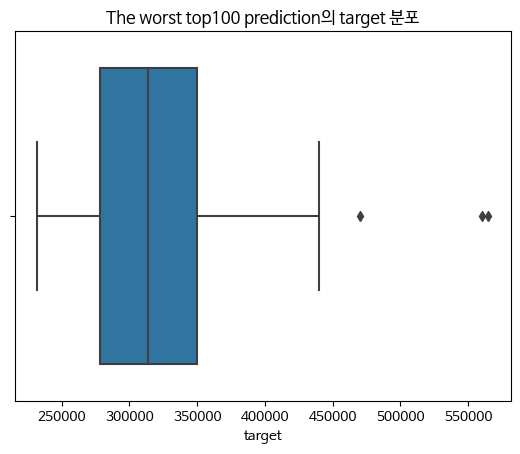

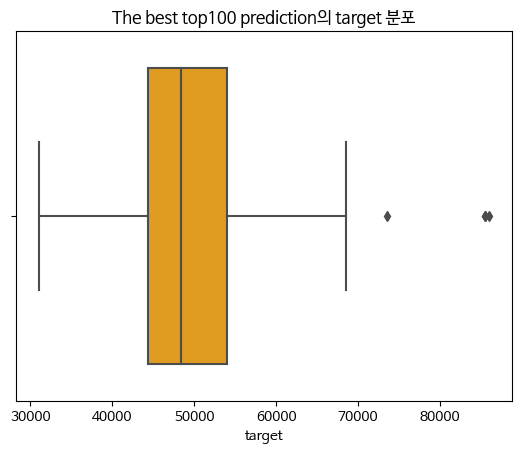

In [88]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

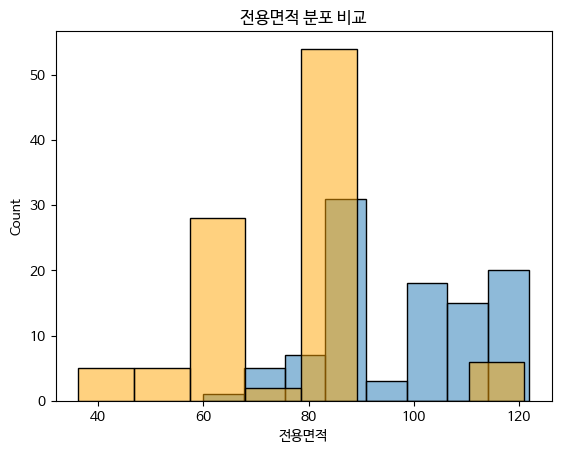

In [89]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [90]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,전화번호,팩스번호,분양형태,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사(시공사),시행사,사용승인일,연면적,주거전용면적,관리비부과면적,60㎡이하세대현황,60㎡~85㎡이하세대현황,85㎡~135㎡이하세대현황,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,X,Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부,노후도,x3,y3,z3,고등학교 거리,학군점수,계약년월일,한국은행 기준금리
1,4112,1086,1,273,79.9700,26,5,1987,5243,3,347,311,2,2,1,1,8.0,270.0,204,167,15,22637.0,20204.0,22637.0,20.0,250.0,0.0,139,408,4,1,4,4858.00,262.0,4,543,1,0,127.057210,37.476763,173,0,0,8,16,6,1,0,38,0.172023,-0.038892,0.984325,521.0,22.553333,20230726,3.5
3,4088,1079,1,5471,108.2017,15,10,2021,407,3,935,1135,2,1,1,4,2.0,232.0,327,437,655,44951.0,24878.0,31174.0,0.0,0.0,232.0,621,408,2,2,2,2724.46,305.0,2,714,1,0,127.056394,37.484892,246,0,0,8,16,7,1,1,4,0.173118,-0.037663,0.984181,521.0,22.553333,20230815,3.5


In [91]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [92]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 35.8 ms, sys: 0 ns, total: 35.8 ms
Wall time: 9.9 ms


In [93]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([110225.62953477, 152842.93478491, 145769.37803308, ...,
        66026.20803417,  49984.71529061,  49984.71529061])

## 7. Output File Save

In [94]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)